In [1]:
import os, glob
import numpy as np
import pandas as pd
import scanpy as sc
import scFates as scf
import matplotlib.pyplot as plt

In [2]:
pth = os.path.join('..', '..')
pth_data = os.path.join(pth, 'data')
pth_in = os.path.join(pth_data, 'modeling', 'inputs')
pth_traj = os.path.join(pth_data, 'trajectories')
pth_reg = os.path.join(pth_data, 'DELAY', 'regulons')
pth_out = os.path.join(pth, 'figures', 'DELAY')

In [3]:
adata = sc.read_h5ad(os.path.join(pth_in, 'development.h5ad'))
adata

AnnData object with n_obs × n_vars = 143369 × 856
    obs: 'Stages', 'Clusters', 'Type', 'LineageAnnotations', 'celltype', 'trajectory', 't', 'training', 'validation', 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'plates', 'devtime', 'location', 'total_counts_ERCC', 'pct_counts_ERCC', 'doublet_scores', 'CytoTRACE', 'Gut_neuron', 'Sensory', 'Symp', 'enFib', 'ChC', 'Gut_glia', 'NCC', 'Mesenchyme', 'Melanocytes', 'SatGlia', 'SC', 'BCC', 'conflict', 'assignments', 'Hub', 'Hub_leiden', 'total_counts_ribo', 'pct_counts_ribo', 'T+ Sox2+', 'batch', 'percent_mito', 'n_counts', 'bh_pval', 'region', 'tissue', 'adj_stage', 'adj_sample', 'S_score', 'G2M_score', 'phase', 'leiden_R', 'celltype_original', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.1', 'seurat_clusters', 'age', 'RNA_snn_res.0.5', 'ident', 'velocity_self_transition', 'source', 'weight_celltype', 'weight_source', 'weight'
    obsm: 'X_diff', 'X_draw_graph_fa', 'X_

In [4]:
reg_fn = sorted(glob.glob(os.path.join(pth_reg, '*.csv')))
get_name = lambda fn: os.path.split(fn)[1].replace('.csv', '')
reg_dict = {get_name(fn) : fn for fn in reg_fn}
for name, fn in reg_dict.items():
    print(name)
    name_gene = f'{name}_Gene'
    name_reg = f'{name}_Regulon'
    g = pd.read_csv(fn).mmusculus
    g = g.loc[g.isin(adata.var_names)]
    for _, df_group in adata.obs.groupby('source', observed = True):
        msk = adata.obs_names.isin(df_group.index)
        adata_group = adata[msk].copy()
        sc.tl.score_genes(adata_group,
                          gene_list = g,
                          ctrl_as_ref = False,
                          score_name = name_reg,
                          random_state = 1234)
        adata.obs.loc[msk, name_reg] = adata_group.obs[name_reg]
    adata.obs[name_gene] = adata[:, name].X.toarray()

Foxc1
Gata4
Prrx2
Snai1
Twist1


In [5]:
cmap = {'Gene' : 'Blues', 'Regulon' : 'Oranges'}

/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


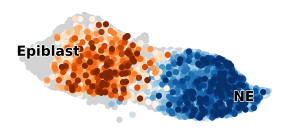

In [6]:
geo, obs_plt = 'GSE162534', ['Gata4_Gene', 'Gata4_Regulon']
vmin, vmax = {'Gata4_Gene' : 1, 'Gata4_Regulon' : .5}, 'p95'
adata_plt = adata[adata.obs.source == geo].copy()
adata_traj = sc.read_h5ad(os.path.join(pth_traj, f'{geo}.h5ad'))
adata_traj = adata_traj[adata_traj.obs_names.isin(adata_plt.obs_names)].copy()
adata_traj.obs[obs_plt] = adata_plt[adata_traj.obs_names].obs[obs_plt].copy()

fig, ax = plt.subplots(1, 1, figsize = (3.5, 1.5))
sc.pl.umap(adata_traj, palette = 'lightgray', size = 80,
           frameon = False, show = False, ax = ax)
for key in obs_plt:
    cmap_key = key.split('_')[1]
    sc.pl.umap(adata_traj[adata_traj.obs[key] > vmin[key]],
               color = key, size = 80, cmap = cmap[cmap_key],
               vmin = vmin[key], vmax = vmax, colorbar_loc = None,
               frameon = False, show = False, ax = ax)
scf.pl.milestones(adata_traj, basis = 'umap', annotate = True,
                  alpha = 0, show = False, ax = ax)
ax.invert_xaxis(); ax.set_title('')

label_dict = {
    'Lateral Plate Mesoderm' : 'NE',
    'Posterior Epiblast'     : 'Epiblast'}

for label in ax.texts:
    _label_ = label.get_text()
    if _label_ in label_dict:
        label.set_text(label_dict[_label_])

fn = os.path.join(pth_out, geo, 'Gata4.pdf')
plt.savefig(fn, bbox_inches = 'tight')

/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


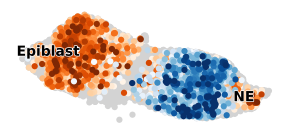

In [7]:
obs_plt = ['Foxc1_Regulon', 'Foxc1_Gene']
vmin = {'Foxc1_Regulon' : .25, 'Foxc1_Gene' : .9}
vmax = {'Foxc1_Regulon' : 'p98', 'Foxc1_Gene' : 'p95'}
adata_traj.obs[obs_plt] = adata_plt[adata_traj.obs_names].obs[obs_plt].copy()

fig, ax = plt.subplots(1, 1, figsize = (3.5, 1.5))
sc.pl.umap(adata_traj, palette = 'lightgray', size = 80,
           frameon = False, show = False, ax = ax)
for key in obs_plt:
    cmap_key = key.split('_')[1]
    sc.pl.umap(adata_traj[adata_traj.obs[key] > vmin[key]],
               color = key, size = 80, cmap = cmap[cmap_key],
               vmin = vmin[key], vmax = vmax[key], colorbar_loc = None,
               frameon = False, show = False, ax = ax)
scf.pl.milestones(adata_traj, basis = 'umap', annotate = True,
                  alpha = 0, show = False, ax = ax)
ax.invert_xaxis(); ax.set_title('')

label_dict = {
    'Lateral Plate Mesoderm' : 'NE',
    'Posterior Epiblast'     : 'Epiblast'}

for label in ax.texts:
    _label_ = label.get_text()
    if _label_ in label_dict:
        label.set_text(label_dict[_label_])

fn = os.path.join(pth_out, geo, 'Foxc1.pdf')
plt.savefig(fn, bbox_inches = 'tight')

/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


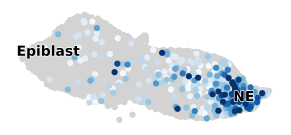

In [8]:
key, vmin, vmax = 'Prrx2_Gene', .8, 'p95'
adata_traj.obs[key] = adata_plt[adata_traj.obs_names].obs[key].copy()

cmap_key = key.split('_')[1]
fig, ax = plt.subplots(1, 1, figsize = (3.5, 1.5))
sc.pl.umap(adata_traj, palette = 'lightgray', size = 80,
           frameon = False, show = False, ax = ax)
sc.pl.umap(adata_traj[adata_traj.obs[key] > vmin],
           color = key, size = 80, cmap = cmap[cmap_key],
           vmin = vmin, vmax = vmax, colorbar_loc = None,
           frameon = False, show = False, ax = ax)
scf.pl.milestones(adata_traj, basis = 'umap', annotate = True,
                  alpha = 0, show = False, ax = ax)
ax.invert_xaxis(); ax.set_title('')

label_dict = {
    'Lateral Plate Mesoderm' : 'NE',
    'Posterior Epiblast'     : 'Epiblast'}

for label in ax.texts:
    _label_ = label.get_text()
    if _label_ in label_dict:
        label.set_text(label_dict[_label_])

fn = os.path.join(pth_out, geo, f'{key}.pdf')
plt.savefig(fn, bbox_inches = 'tight')

/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


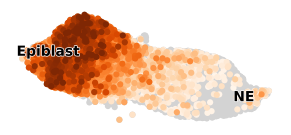

In [9]:
key, vmin, vmax = 'Prrx2_Regulon', .25, 'p99'
adata_traj.obs[key] = adata_plt[adata_traj.obs_names].obs[key].copy()

cmap_key = key.split('_')[1]
fig, ax = plt.subplots(1, 1, figsize = (3.5, 1.5))
sc.pl.umap(adata_traj, palette = 'lightgray', size = 80,
           frameon = False, show = False, ax = ax)
sc.pl.umap(adata_traj[adata_traj.obs[key] > vmin],
           color = key, size = 80, cmap = cmap[cmap_key],
           vmin = vmin, vmax = vmax, colorbar_loc = None,
           frameon = False, show = False, ax = ax)
scf.pl.milestones(adata_traj, basis = 'umap', annotate = True,
                  alpha = 0, show = False, ax = ax)
ax.invert_xaxis(); ax.set_title('')

label_dict = {
    'Lateral Plate Mesoderm' : 'NE',
    'Posterior Epiblast'     : 'Epiblast'}

for label in ax.texts:
    _label_ = label.get_text()
    if _label_ in label_dict:
        label.set_text(label_dict[_label_])

fn = os.path.join(pth_out, geo, f'{key}.pdf')
plt.savefig(fn, bbox_inches = 'tight')

/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


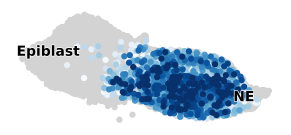

In [10]:
key, vmin, vmax = 'Snai1_Gene', 2, 'p95'
adata_traj.obs[key] = adata_plt[adata_traj.obs_names].obs[key].copy()

cmap_key = key.split('_')[1]
fig, ax = plt.subplots(1, 1, figsize = (3.5, 1.5))
sc.pl.umap(adata_traj, palette = 'lightgray', size = 80,
           frameon = False, show = False, ax = ax)
sc.pl.umap(adata_traj[adata_traj.obs[key] > vmin],
           color = key, size = 80, cmap = cmap[cmap_key],
           vmin = vmin, vmax = vmax, colorbar_loc = None,
           frameon = False, show = False, ax = ax)
scf.pl.milestones(adata_traj, basis = 'umap', annotate = True,
                  alpha = 0, show = False, ax = ax)
ax.invert_xaxis(); ax.set_title('')

label_dict = {
    'Lateral Plate Mesoderm' : 'NE',
    'Posterior Epiblast'     : 'Epiblast'}

for label in ax.texts:
    _label_ = label.get_text()
    if _label_ in label_dict:
        label.set_text(label_dict[_label_])

fn = os.path.join(pth_out, geo, f'{key}.pdf')
plt.savefig(fn, bbox_inches = 'tight')

/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


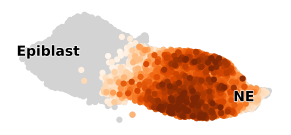

In [11]:
key, vmin, vmax = 'Snai1_Regulon', 0, 'p99'
adata_traj.obs[key] = adata_plt[adata_traj.obs_names].obs[key].copy()

cmap_key = key.split('_')[1]
fig, ax = plt.subplots(1, 1, figsize = (3.5, 1.5))
sc.pl.umap(adata_traj, palette = 'lightgray', size = 80,
           frameon = False, show = False, ax = ax)
sc.pl.umap(adata_traj[adata_traj.obs[key] > vmin],
           color = key, size = 80, cmap = cmap[cmap_key],
           vmin = vmin, vmax = vmax, colorbar_loc = None,
           frameon = False, show = False, ax = ax)
scf.pl.milestones(adata_traj, basis = 'umap', annotate = True,
                  alpha = 0, show = False, ax = ax)
ax.invert_xaxis(); ax.set_title('')

label_dict = {
    'Lateral Plate Mesoderm' : 'NE',
    'Posterior Epiblast'     : 'Epiblast'}

for label in ax.texts:
    _label_ = label.get_text()
    if _label_ in label_dict:
        label.set_text(label_dict[_label_])

fn = os.path.join(pth_out, geo, f'{key}.pdf')
plt.savefig(fn, bbox_inches = 'tight')

/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


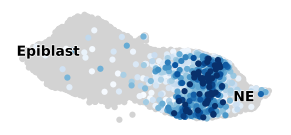

In [12]:
key, vmin, vmax = 'Twist1_Gene', 1, 'p95'
adata_traj.obs[key] = adata_plt[adata_traj.obs_names].obs[key].copy()

cmap_key = key.split('_')[1]
fig, ax = plt.subplots(1, 1, figsize = (3.5, 1.5))
sc.pl.umap(adata_traj, palette = 'lightgray', size = 80,
           frameon = False, show = False, ax = ax)
sc.pl.umap(adata_traj[adata_traj.obs[key] > vmin],
           color = key, size = 80, cmap = cmap[cmap_key],
           vmin = vmin, vmax = vmax, colorbar_loc = None,
           frameon = False, show = False, ax = ax)
scf.pl.milestones(adata_traj, basis = 'umap', annotate = True,
                  alpha = 0, show = False, ax = ax)
ax.invert_xaxis(); ax.set_title('')

label_dict = {
    'Lateral Plate Mesoderm' : 'NE',
    'Posterior Epiblast'     : 'Epiblast'}

for label in ax.texts:
    _label_ = label.get_text()
    if _label_ in label_dict:
        label.set_text(label_dict[_label_])

fn = os.path.join(pth_out, geo, f'{key}.pdf')
plt.savefig(fn, bbox_inches = 'tight')

/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


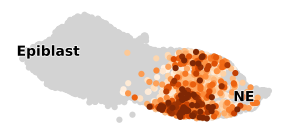

In [13]:
key, vmin, vmax = 'Twist1_Regulon', .05, 'p95'
adata_traj.obs[key] = adata_plt[adata_traj.obs_names].obs[key].copy()

cmap_key = key.split('_')[1]
fig, ax = plt.subplots(1, 1, figsize = (3.5, 1.5))
sc.pl.umap(adata_traj, palette = 'lightgray', size = 80,
           frameon = False, show = False, ax = ax)
sc.pl.umap(adata_traj[adata_traj.obs[key] > vmin],
           color = key, size = 80, cmap = cmap[cmap_key],
           vmin = vmin, vmax = vmax, colorbar_loc = None,
           frameon = False, show = False, ax = ax)
scf.pl.milestones(adata_traj, basis = 'umap', annotate = True,
                  alpha = 0, show = False, ax = ax)
ax.invert_xaxis(); ax.set_title('')

label_dict = {
    'Lateral Plate Mesoderm' : 'NE',
    'Posterior Epiblast'     : 'Epiblast'}

for label in ax.texts:
    _label_ = label.get_text()
    if _label_ in label_dict:
        label.set_text(label_dict[_label_])

fn = os.path.join(pth_out, geo, f'{key}.pdf')
plt.savefig(fn, bbox_inches = 'tight')

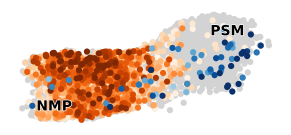

In [14]:
geo, obs_plt = 'GSE229103', ['Gata4_Regulon', 'Gata4_Gene']
vmin = {'Gata4_Gene' : 0, 'Gata4_Regulon' : .2}
vmax = {'Gata4_Gene' : 'p75', 'Gata4_Regulon' : 'p98'}
adata_plt = adata[adata.obs.source == geo].copy()
adata_traj = sc.read_h5ad(os.path.join(pth_traj, f'{geo}.h5ad'))
adata_traj = adata_traj[adata_traj.obs_names.isin(adata_plt.obs_names)].copy()
adata_traj.obs[obs_plt] = adata_plt[adata_traj.obs_names].obs[obs_plt].copy()

fig, ax = plt.subplots(1, 1, figsize = (3.5, 1.5))
sc.pl.umap(adata_traj, dimensions = [1, 0], palette = 'lightgray',
           size = 80, frameon = False, show = False, ax = ax)
for key in obs_plt:
    cmap_key = key.split('_')[1]
    sc.pl.umap(adata_traj[adata_traj.obs[key] > vmin[key]],
                dimensions = [1, 0], color = key, size = 80,
                cmap = cmap[cmap_key], vmin = vmin[key],
                vmax = vmax[key], colorbar_loc = None,
                frameon = False, show = False, ax = ax)
sc.pl.umap(adata_traj, dimensions = [1, 0], color = 'milestones',
           alpha = 0, legend_loc = 'on data', legend_fontoutline = 1,
           show = False, ax = ax)
ax.invert_xaxis(); ax.set_title('')

label_dict = {
    'Presomitic Mesoderm'        : 'PSM',
    'Neuromesodermal Progenitor' : 'NMP'}

pos_dict = {
    'Neuromesodermal Progenitor' : (1.5, -1.75),
    'Presomitic Mesoderm'        : (-1.33, 1.75)}

for label in ax.texts:
    _label_ = label.get_text()
    x, y = label.get_position()
    if _label_ in label_dict:
        label.set_text(label_dict[_label_])
    if _label_ in pos_dict:
        dx, dy = pos_dict[_label_]
        label.set_position([x + dx, y + dy])

fn = os.path.join(pth_out, geo, 'Gata4.pdf')
plt.savefig(fn, bbox_inches = 'tight')

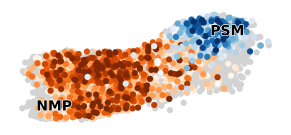

In [15]:
obs_plt = ['Foxc1_Regulon', 'Foxc1_Gene']
vmin, vmax = {'Foxc1_Gene' : .8, 'Foxc1_Regulon' : .125}, 'p95'
adata_traj.obs[obs_plt] = adata_plt[adata_traj.obs_names].obs[obs_plt].copy()

fig, ax = plt.subplots(1, 1, figsize = (3.5, 1.5))
sc.pl.umap(adata_traj, dimensions = [1, 0], palette = 'lightgray',
           size = 80, frameon = False, show = False, ax = ax)
for key in obs_plt:
    cmap_key = key.split('_')[1]
    sc.pl.umap(adata_traj[adata_traj.obs[key] > vmin[key]],
                dimensions = [1, 0], color = key, size = 80,
                cmap = cmap[cmap_key], vmin = vmin[key],
                vmax = vmax, colorbar_loc = None,
                frameon = False, show = False, ax = ax)
sc.pl.umap(adata_traj, dimensions = [1, 0], color = 'milestones',
           alpha = 0, legend_loc = 'on data', legend_fontoutline = 1,
           show = False, ax = ax)
ax.invert_xaxis(); ax.set_title('')

label_dict = {
    'Presomitic Mesoderm'        : 'PSM',
    'Neuromesodermal Progenitor' : 'NMP'}

pos_dict = {
    'Neuromesodermal Progenitor' : (1.5, -1.75),
    'Presomitic Mesoderm'        : (-1.33, 1.75)}

for label in ax.texts:
    _label_ = label.get_text()
    x, y = label.get_position()
    if _label_ in label_dict:
        label.set_text(label_dict[_label_])
    if _label_ in pos_dict:
        dx, dy = pos_dict[_label_]
        label.set_position([x + dx, y + dy])

fn = os.path.join(pth_out, geo, 'Foxc1.pdf')
plt.savefig(fn, bbox_inches = 'tight')

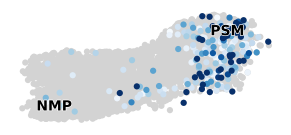

In [16]:
key, vmin, vmax = 'Prrx2_Gene', .5, 'p80'
adata_traj.obs[key] = adata_plt[adata_traj.obs_names].obs[key].copy()

cmap_key = key.split('_')[1]
fig, ax = plt.subplots(1, 1, figsize = (3.5, 1.5))
sc.pl.umap(adata_traj, dimensions = [1, 0], palette = 'lightgray',
           size = 80, frameon = False, show = False, ax = ax)
sc.pl.umap(adata_traj[adata_traj.obs[key] > vmin],
           dimensions = [1, 0], color = key, size = 80,
           cmap = cmap[cmap_key], vmin = vmin, vmax = vmax,
           colorbar_loc = None, frameon = False, show = False,
           ax = ax)
sc.pl.umap(adata_traj, dimensions = [1, 0], color = 'milestones',
           alpha = 0, legend_loc = 'on data', legend_fontoutline = 1,
           show = False, ax = ax)
ax.invert_xaxis(); ax.set_title('')

label_dict = {
    'Presomitic Mesoderm'        : 'PSM',
    'Neuromesodermal Progenitor' : 'NMP'}

pos_dict = {
    'Neuromesodermal Progenitor' : (1.5, -1.75),
    'Presomitic Mesoderm'        : (-1.33, 1.75)}

for label in ax.texts:
    _label_ = label.get_text()
    x, y = label.get_position()
    if _label_ in label_dict:
        label.set_text(label_dict[_label_])
    if _label_ in pos_dict:
        dx, dy = pos_dict[_label_]
        label.set_position([x + dx, y + dy])

fn = os.path.join(pth_out, geo, f'{key}.pdf')
plt.savefig(fn, bbox_inches = 'tight')

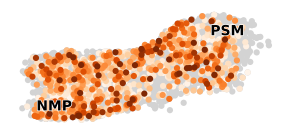

In [17]:
key, vmin, vmax = 'Prrx2_Regulon', .01, 'p98'
adata_traj.obs[key] = adata_plt[adata_traj.obs_names].obs[key].copy()

cmap_key = key.split('_')[1]
fig, ax = plt.subplots(1, 1, figsize = (3.5, 1.5))
sc.pl.umap(adata_traj, dimensions = [1, 0], palette = 'lightgray',
           size = 80, frameon = False, show = False, ax = ax)
sc.pl.umap(adata_traj[adata_traj.obs[key] > vmin],
           dimensions = [1, 0], color = key, size = 80,
           cmap = cmap[cmap_key], vmin = vmin, vmax = vmax,
           colorbar_loc = None, frameon = False, show = False,
           ax = ax)
sc.pl.umap(adata_traj, dimensions = [1, 0], color = 'milestones',
           alpha = 0, legend_loc = 'on data', legend_fontoutline = 1,
           show = False, ax = ax)
ax.invert_xaxis(); ax.set_title('')

label_dict = {
    'Presomitic Mesoderm'        : 'PSM',
    'Neuromesodermal Progenitor' : 'NMP'}

pos_dict = {
    'Neuromesodermal Progenitor' : (1.5, -1.75),
    'Presomitic Mesoderm'        : (-1.33, 1.75)}

for label in ax.texts:
    _label_ = label.get_text()
    x, y = label.get_position()
    if _label_ in label_dict:
        label.set_text(label_dict[_label_])
    if _label_ in pos_dict:
        dx, dy = pos_dict[_label_]
        label.set_position([x + dx, y + dy])

fn = os.path.join(pth_out, geo, f'{key}.pdf')
plt.savefig(fn, bbox_inches = 'tight')

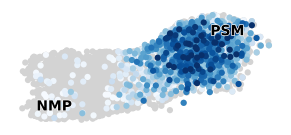

In [18]:
key, vmin, vmax = 'Snai1_Gene', .5, 'p98'
adata_traj.obs[key] = adata_plt[adata_traj.obs_names].obs[key].copy()

cmap_key = key.split('_')[1]
fig, ax = plt.subplots(1, 1, figsize = (3.5, 1.5))
sc.pl.umap(adata_traj, dimensions = [1, 0], palette = 'lightgray',
           size = 80, frameon = False, show = False, ax = ax)
sc.pl.umap(adata_traj[adata_traj.obs[key] > vmin],
           dimensions = [1, 0], color = key, size = 80,
           cmap = cmap[cmap_key], vmin = vmin, vmax = vmax,
           colorbar_loc = None, frameon = False, show = False,
           ax = ax)
sc.pl.umap(adata_traj, dimensions = [1, 0], color = 'milestones',
           alpha = 0, legend_loc = 'on data', legend_fontoutline = 1,
           show = False, ax = ax)
ax.invert_xaxis(); ax.set_title('')

label_dict = {
    'Presomitic Mesoderm'        : 'PSM',
    'Neuromesodermal Progenitor' : 'NMP'}

pos_dict = {
    'Neuromesodermal Progenitor' : (1.5, -1.75),
    'Presomitic Mesoderm'        : (-1.33, 1.75)}

for label in ax.texts:
    _label_ = label.get_text()
    x, y = label.get_position()
    if _label_ in label_dict:
        label.set_text(label_dict[_label_])
    if _label_ in pos_dict:
        dx, dy = pos_dict[_label_]
        label.set_position([x + dx, y + dy])

fn = os.path.join(pth_out, geo, f'{key}.pdf')
plt.savefig(fn, bbox_inches = 'tight')

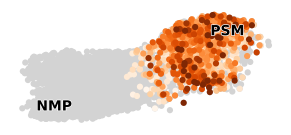

In [19]:
key, vmin, vmax = 'Snai1_Regulon', -.15, 'p98'
adata_traj.obs[key] = adata_plt[adata_traj.obs_names].obs[key].copy()

cmap_key = key.split('_')[1]
fig, ax = plt.subplots(1, 1, figsize = (3.5, 1.5))
sc.pl.umap(adata_traj, dimensions = [1, 0], palette = 'lightgray',
           size = 80, frameon = False, show = False, ax = ax)
sc.pl.umap(adata_traj[adata_traj.obs[key] > vmin],
           dimensions = [1, 0], color = key, size = 80,
           cmap = cmap[cmap_key], vmin = vmin, vmax = vmax,
           colorbar_loc = None, frameon = False, show = False,
           ax = ax)
sc.pl.umap(adata_traj, dimensions = [1, 0], color = 'milestones',
           alpha = 0, legend_loc = 'on data', legend_fontoutline = 1,
           show = False, ax = ax)
ax.invert_xaxis(); ax.set_title('')

label_dict = {
    'Presomitic Mesoderm'        : 'PSM',
    'Neuromesodermal Progenitor' : 'NMP'}

pos_dict = {
    'Neuromesodermal Progenitor' : (1.5, -1.75),
    'Presomitic Mesoderm'        : (-1.33, 1.75)}

for label in ax.texts:
    _label_ = label.get_text()
    x, y = label.get_position()
    if _label_ in label_dict:
        label.set_text(label_dict[_label_])
    if _label_ in pos_dict:
        dx, dy = pos_dict[_label_]
        label.set_position([x + dx, y + dy])

fn = os.path.join(pth_out, geo, f'{key}.pdf')
plt.savefig(fn, bbox_inches = 'tight')

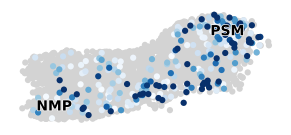

In [20]:
key, vmin, vmax = 'Twist1_Gene', .5, 'p80'
adata_traj.obs[key] = adata_plt[adata_traj.obs_names].obs[key].copy()

cmap_key = key.split('_')[1]
fig, ax = plt.subplots(1, 1, figsize = (3.5, 1.5))
sc.pl.umap(adata_traj, dimensions = [1, 0], palette = 'lightgray',
           size = 80, frameon = False, show = False, ax = ax)
sc.pl.umap(adata_traj[adata_traj.obs[key] > vmin],
           dimensions = [1, 0], color = key, size = 80,
           cmap = cmap[cmap_key], vmin = vmin, vmax = vmax,
           colorbar_loc = None, frameon = False, show = False,
           ax = ax)
sc.pl.umap(adata_traj, dimensions = [1, 0], color = 'milestones',
           alpha = 0, legend_loc = 'on data', legend_fontoutline = 1,
           show = False, ax = ax)
ax.invert_xaxis(); ax.set_title('')

label_dict = {
    'Presomitic Mesoderm'        : 'PSM',
    'Neuromesodermal Progenitor' : 'NMP'}

pos_dict = {
    'Neuromesodermal Progenitor' : (1.5, -1.75),
    'Presomitic Mesoderm'        : (-1.33, 1.75)}

for label in ax.texts:
    _label_ = label.get_text()
    x, y = label.get_position()
    if _label_ in label_dict:
        label.set_text(label_dict[_label_])
    if _label_ in pos_dict:
        dx, dy = pos_dict[_label_]
        label.set_position([x + dx, y + dy])

fn = os.path.join(pth_out, geo, f'{key}.pdf')
plt.savefig(fn, bbox_inches = 'tight')

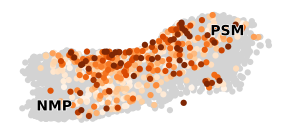

In [21]:
key, vmin, vmax = 'Twist1_Regulon', .05, 'p95'
adata_traj.obs[key] = adata_plt[adata_traj.obs_names].obs[key].copy()

cmap_key = key.split('_')[1]
fig, ax = plt.subplots(1, 1, figsize = (3.5, 1.5))
sc.pl.umap(adata_traj, dimensions = [1, 0], palette = 'lightgray',
           size = 80, frameon = False, show = False, ax = ax)
sc.pl.umap(adata_traj[adata_traj.obs[key] > vmin],
           dimensions = [1, 0], color = key, size = 80,
           cmap = cmap[cmap_key], vmin = vmin, vmax = vmax,
           colorbar_loc = None, frameon = False, show = False,
           ax = ax)
sc.pl.umap(adata_traj, dimensions = [1, 0], color = 'milestones',
           alpha = 0, legend_loc = 'on data', legend_fontoutline = 1,
           show = False, ax = ax)
ax.invert_xaxis(); ax.set_title('')

label_dict = {
    'Presomitic Mesoderm'        : 'PSM',
    'Neuromesodermal Progenitor' : 'NMP'}

pos_dict = {
    'Neuromesodermal Progenitor' : (1.5, -1.75),
    'Presomitic Mesoderm'        : (-1.33, 1.75)}

for label in ax.texts:
    _label_ = label.get_text()
    x, y = label.get_position()
    if _label_ in label_dict:
        label.set_text(label_dict[_label_])
    if _label_ in pos_dict:
        dx, dy = pos_dict[_label_]
        label.set_position([x + dx, y + dy])

fn = os.path.join(pth_out, geo, f'{key}.pdf')
plt.savefig(fn, bbox_inches = 'tight')

/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


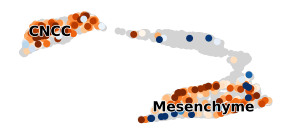

In [22]:
geo = 'rRNAModifications'
obs_plt = ['Gata4_Regulon', 'Gata4_Gene']
vmin = {'Gata4_Gene' : 0, 'Gata4_Regulon' : .25}
vmax = {'Gata4_Gene' : 'p60', 'Gata4_Regulon' : 'p95'}
adata_plt = adata[adata.obs.source == geo].copy()
adata_traj = sc.read_h5ad(os.path.join(pth_traj, f'{geo}.h5ad'))
adata_traj = adata_traj[adata_traj.obs_names.isin(adata_plt.obs_names)].copy()
adata_traj.obs[obs_plt] = adata_plt[adata_traj.obs_names].obs[obs_plt].copy()

fig, ax = plt.subplots(1, 1, figsize = (3.5, 1.5))
sc.pl.umap(adata_traj, palette = 'lightgray', size = 100,
           frameon = False, show = False, ax = ax)
for key in obs_plt:
    cmap_key = key.split('_')[1]
    sc.pl.umap(adata_traj[adata_traj.obs[key] > vmin[key]],
               color = key, cmap = cmap[cmap_key], vmin = vmin[key],
               vmax = vmax[key], size = 100, colorbar_loc = None,
               frameon = False, show = False, ax = ax)
scf.pl.milestones(adata_traj, basis = 'umap', annotate = True,
                  alpha = 0, show = False, ax = ax)
ax.invert_yaxis(); ax.set_title('')

label_dict = {
    'migr_ncc'   : '',
    'mes_fork'   : '',
    'mes2'       : '',
    'neuroglial' : '',
    'root'       : 'CNCC',
    'mes1'       : 'Mesenchyme'}

pos_dict = {
    'root' : (.75, -1.25),
    'mes1' : (1.75, -.25)}

for label in ax.texts:
    _label_ = label.get_text()
    x, y = label.get_position()
    if _label_ in label_dict:
        label.set_text(label_dict[_label_])
    if _label_ in pos_dict:
        dx, dy = pos_dict[_label_]
        label.set_position([x + dx, y + dy])

fn = os.path.join(pth_out, geo, 'Gata4.pdf')
plt.savefig(fn, bbox_inches = 'tight')

/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


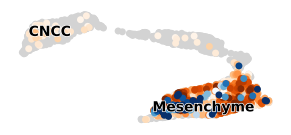

In [23]:
obs_plt = ['Foxc1_Regulon', 'Foxc1_Gene']
vmin = {'Foxc1_Gene' : .8, 'Foxc1_Regulon' : .2}
vmax = {'Foxc1_Gene' : 'p55', 'Foxc1_Regulon' : 'p99'}
adata_traj.obs[obs_plt] = adata_plt[adata_traj.obs_names].obs[obs_plt].copy()

fig, ax = plt.subplots(1, 1, figsize = (3.5, 1.5))
sc.pl.umap(adata_traj, palette = 'lightgray', size = 100,
           frameon = False, show = False, ax = ax)
for key in obs_plt:
    cmap_key = key.split('_')[1]
    sc.pl.umap(adata_traj[adata_traj.obs[key] > vmin[key]],
               color = key, cmap = cmap[cmap_key], vmin = vmin[key],
               vmax = vmax[key], size = 100, colorbar_loc = None,
               frameon = False, show = False, ax = ax)
scf.pl.milestones(adata_traj, basis = 'umap', annotate = True,
                  alpha = 0, show = False, ax = ax)
ax.invert_yaxis(); ax.set_title('')

label_dict = {
    'migr_ncc'   : '',
    'mes_fork'   : '',
    'mes2'       : '',
    'neuroglial' : '',
    'root'       : 'CNCC',
    'mes1'       : 'Mesenchyme'}

pos_dict = {
    'root' : (.75, -1.25),
    'mes1' : (1.75, -.25)}

for label in ax.texts:
    _label_ = label.get_text()
    x, y = label.get_position()
    if _label_ in label_dict:
        label.set_text(label_dict[_label_])
    if _label_ in pos_dict:
        dx, dy = pos_dict[_label_]
        label.set_position([x + dx, y + dy])

fn = os.path.join(pth_out, geo, 'Foxc1.pdf')
plt.savefig(fn, bbox_inches = 'tight')

/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


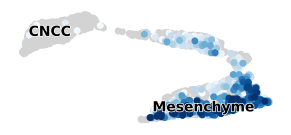

In [24]:
key, vmin, vmax = 'Prrx2_Gene', .5, 'p95'
adata_traj.obs[key] = adata_plt[adata_traj.obs_names].obs[key].copy()

cmap_key = key.split('_')[1]
fig, ax = plt.subplots(1, 1, figsize = (3.5, 1.5))
sc.pl.umap(adata_traj, palette = 'lightgray', size = 100,
           frameon = False, show = False, ax = ax)
sc.pl.umap(adata_traj[adata_traj.obs[key] > vmin],
           color = key, cmap = cmap[cmap_key], vmin = vmin,
           vmax = vmax, size = 100, colorbar_loc = None,
           frameon = False, show = False, ax = ax)
scf.pl.milestones(adata_traj, basis = 'umap', annotate = True,
                  alpha = 0, show = False, ax = ax)
ax.invert_yaxis(); ax.set_title('')

label_dict = {
    'migr_ncc'   : '',
    'mes_fork'   : '',
    'mes2'       : '',
    'neuroglial' : '',
    'root'       : 'CNCC',
    'mes1'       : 'Mesenchyme'}

pos_dict = {
    'root' : (.75, -1.25),
    'mes1' : (1.75, -.25)}

for label in ax.texts:
    _label_ = label.get_text()
    x, y = label.get_position()
    if _label_ in label_dict:
        label.set_text(label_dict[_label_])
    if _label_ in pos_dict:
        dx, dy = pos_dict[_label_]
        label.set_position([x + dx, y + dy])

fn = os.path.join(pth_out, geo, f'{key}.pdf')
plt.savefig(fn, bbox_inches = 'tight')

/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


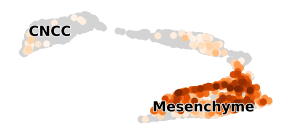

In [25]:
key, vmin, vmax = 'Prrx2_Regulon', .15, 'p99'
adata_traj.obs[key] = adata_plt[adata_traj.obs_names].obs[key].copy()

cmap_key = key.split('_')[1]
fig, ax = plt.subplots(1, 1, figsize = (3.5, 1.5))
sc.pl.umap(adata_traj, palette = 'lightgray', size = 100,
           frameon = False, show = False, ax = ax)
sc.pl.umap(adata_traj[adata_traj.obs[key] > vmin],
           color = key, cmap = cmap[cmap_key], vmin = vmin,
           vmax = vmax, size = 100, colorbar_loc = None,
           frameon = False, show = False, ax = ax)
scf.pl.milestones(adata_traj, basis = 'umap', annotate = True,
                  alpha = 0, show = False, ax = ax)
ax.invert_yaxis(); ax.set_title('')

label_dict = {
    'migr_ncc'   : '',
    'mes_fork'   : '',
    'mes2'       : '',
    'neuroglial' : '',
    'root'       : 'CNCC',
    'mes1'       : 'Mesenchyme'}

pos_dict = {
    'root' : (.75, -1.25),
    'mes1' : (1.75, -.25)}

for label in ax.texts:
    _label_ = label.get_text()
    x, y = label.get_position()
    if _label_ in label_dict:
        label.set_text(label_dict[_label_])
    if _label_ in pos_dict:
        dx, dy = pos_dict[_label_]
        label.set_position([x + dx, y + dy])

fn = os.path.join(pth_out, geo, f'{key}.pdf')
plt.savefig(fn, bbox_inches = 'tight')

/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


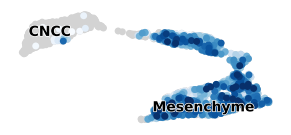

In [26]:
key, vmin, vmax = 'Snai1_Gene', .2, 'p98'
adata_traj.obs[key] = adata_plt[adata_traj.obs_names].obs[key].copy()

cmap_key = key.split('_')[1]
fig, ax = plt.subplots(1, 1, figsize = (3.5, 1.5))
sc.pl.umap(adata_traj, palette = 'lightgray', size = 100,
           frameon = False, show = False, ax = ax)
sc.pl.umap(adata_traj[adata_traj.obs[key] > vmin],
           color = key, cmap = cmap[cmap_key], vmin = vmin,
           vmax = vmax, size = 100, colorbar_loc = None,
           frameon = False, show = False, ax = ax)
scf.pl.milestones(adata_traj, basis = 'umap', annotate = True,
                  alpha = 0, show = False, ax = ax)
ax.invert_yaxis(); ax.set_title('')

label_dict = {
    'migr_ncc'   : '',
    'mes_fork'   : '',
    'mes2'       : '',
    'neuroglial' : '',
    'root'       : 'CNCC',
    'mes1'       : 'Mesenchyme'}

pos_dict = {
    'root' : (.75, -1.25),
    'mes1' : (1.75, -.25)}

for label in ax.texts:
    _label_ = label.get_text()
    x, y = label.get_position()
    if _label_ in label_dict:
        label.set_text(label_dict[_label_])
    if _label_ in pos_dict:
        dx, dy = pos_dict[_label_]
        label.set_position([x + dx, y + dy])

fn = os.path.join(pth_out, geo, f'{key}.pdf')
plt.savefig(fn, bbox_inches = 'tight')

/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


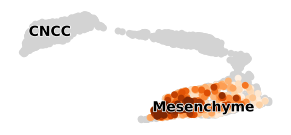

In [27]:
key, vmin, vmax = 'Snai1_Regulon', 0, 'p95'
adata_traj.obs[key] = adata_plt[adata_traj.obs_names].obs[key].copy()

cmap_key = key.split('_')[1]
fig, ax = plt.subplots(1, 1, figsize = (3.5, 1.5))
sc.pl.umap(adata_traj, palette = 'lightgray', size = 100,
           frameon = False, show = False, ax = ax)
sc.pl.umap(adata_traj[adata_traj.obs[key] > vmin],
           color = key, cmap = cmap[cmap_key], vmin = vmin,
           vmax = vmax, size = 100, colorbar_loc = None,
           frameon = False, show = False, ax = ax)
scf.pl.milestones(adata_traj, basis = 'umap', annotate = True,
                  alpha = 0, show = False, ax = ax)
ax.invert_yaxis(); ax.set_title('')

label_dict = {
    'migr_ncc'   : '',
    'mes_fork'   : '',
    'mes2'       : '',
    'neuroglial' : '',
    'root'       : 'CNCC',
    'mes1'       : 'Mesenchyme'}

pos_dict = {
    'root' : (.75, -1.25),
    'mes1' : (1.75, -.25)}

for label in ax.texts:
    _label_ = label.get_text()
    x, y = label.get_position()
    if _label_ in label_dict:
        label.set_text(label_dict[_label_])
    if _label_ in pos_dict:
        dx, dy = pos_dict[_label_]
        label.set_position([x + dx, y + dy])

fn = os.path.join(pth_out, geo, f'{key}.pdf')
plt.savefig(fn, bbox_inches = 'tight')

/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


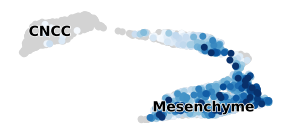

In [28]:
key, vmin, vmax = 'Twist1_Gene', .2, 'p98'
adata_traj.obs[key] = adata_plt[adata_traj.obs_names].obs[key].copy()

cmap_key = key.split('_')[1]
fig, ax = plt.subplots(1, 1, figsize = (3.5, 1.5))
sc.pl.umap(adata_traj, palette = 'lightgray', size = 100,
           frameon = False, show = False, ax = ax)
sc.pl.umap(adata_traj[adata_traj.obs[key] > vmin],
           color = key, cmap = cmap[cmap_key], vmin = vmin,
           vmax = vmax, size = 100, colorbar_loc = None,
           frameon = False, show = False, ax = ax)
scf.pl.milestones(adata_traj, basis = 'umap', annotate = True,
                  alpha = 0, show = False, ax = ax)
ax.invert_yaxis(); ax.set_title('')

label_dict = {
    'migr_ncc'   : '',
    'mes_fork'   : '',
    'mes2'       : '',
    'neuroglial' : '',
    'root'       : 'CNCC',
    'mes1'       : 'Mesenchyme'}

pos_dict = {
    'root' : (.75, -1.25),
    'mes1' : (1.75, -.25)}

for label in ax.texts:
    _label_ = label.get_text()
    x, y = label.get_position()
    if _label_ in label_dict:
        label.set_text(label_dict[_label_])
    if _label_ in pos_dict:
        dx, dy = pos_dict[_label_]
        label.set_position([x + dx, y + dy])

fn = os.path.join(pth_out, geo, f'{key}.pdf')
plt.savefig(fn, bbox_inches = 'tight')

/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


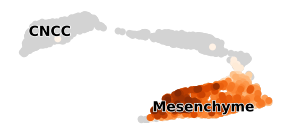

In [29]:
key, vmin, vmax = 'Twist1_Regulon', .1, 'p99'
adata_traj.obs[key] = adata_plt[adata_traj.obs_names].obs[key].copy()

cmap_key = key.split('_')[1]
fig, ax = plt.subplots(1, 1, figsize = (3.5, 1.5))
sc.pl.umap(adata_traj, palette = 'lightgray', size = 100,
           frameon = False, show = False, ax = ax)
sc.pl.umap(adata_traj[adata_traj.obs[key] > vmin],
           color = key, cmap = cmap[cmap_key], vmin = vmin,
           vmax = vmax, size = 100, colorbar_loc = None,
           frameon = False, show = False, ax = ax)
scf.pl.milestones(adata_traj, basis = 'umap', annotate = True,
                  alpha = 0, show = False, ax = ax)
ax.invert_yaxis(); ax.set_title('')

label_dict = {
    'migr_ncc'   : '',
    'mes_fork'   : '',
    'mes2'       : '',
    'neuroglial' : '',
    'root'       : 'CNCC',
    'mes1'       : 'Mesenchyme'}

pos_dict = {
    'root' : (.75, -1.25),
    'mes1' : (1.75, -.25)}

for label in ax.texts:
    _label_ = label.get_text()
    x, y = label.get_position()
    if _label_ in label_dict:
        label.set_text(label_dict[_label_])
    if _label_ in pos_dict:
        dx, dy = pos_dict[_label_]
        label.set_position([x + dx, y + dy])

fn = os.path.join(pth_out, geo, f'{key}.pdf')
plt.savefig(fn, bbox_inches = 'tight')